# PRI Lab 2

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt

## Exercise 1

In [3]:
from whoosh import index, fields, qparser

In [4]:
def whoosh_indexing(file):
    if not os.path.exists('index_lab2'): os.mkdir('index_lab2')
    schema = fields.Schema(id=fields.NUMERIC(stored=True), content=fields.TEXT)
    ix = index.create_in("index_lab2", schema)
    writer = ix.writer()
    with open(file, 'r') as f:
        for identifier, line in enumerate(f):
            writer.add_document(id=identifier, content=line)
    writer.commit()
    return ix

In [5]:
def retrieve_docs(index, query):
    with index.searcher() as searcher:
        q = qparser.QueryParser("content", index.schema, group=qparser.OrGroup).parse(query)
        return set(searcher.docs_for_query(q))

In [6]:
def precision(docs, relevant_docs):
    return len(relevant_docs.intersection(docs))/len(docs)

def recall(docs, relevant_docs):
    return len(relevant_docs.intersection(docs))/len(relevant_docs)

def F1(id_list, rel_set_ids):
    p = precision(id_list,rel_set_ids)
    r = recall(id_list,rel_set_ids)
    if p+r == 0: return 0
    return 2 * (p*r) / (p+r)

In [7]:
myindex = whoosh_indexing("pri_cfc.txt")

In [8]:
with open('pri_queries.txt') as f:
    limit = 5
    query = True
    docs = set()
    for i,line in enumerate(f):
        if i==limit*2: break
        if query: docs = retrieve_docs(myindex, line)
        else: 
            relevant_docs = {int(x) for x in line.split()}
            print("F1 for query Q%d:%.3f"%(i/2,F1(docs,relevant_docs)))
        query = not(query)

F1 for query Q0:0.052
F1 for query Q1:0.006
F1 for query Q2:0.073
F1 for query Q3:0.016
F1 for query Q4:0.144


## Exercise 2

In [9]:
from sklearn.feature_extraction import text

In [10]:
def sklearn_vectorizer(documents, tfidf=False):
    vectorizer = text.TfidfVectorizer() if tfidf else text.CountVectorizer()
    data = vectorizer.fit_transform(documents)
    features = vectorizer.get_feature_names_out()
    return data, features

In [12]:
collection = []
with open("pri_cfc.txt", 'r') as f:
    for line in f:
        collection.append(line)
data, features = sklearn_vectorizer(collection,True)
pd.DataFrame(np.array(data.toarray()),columns=features).head()

,00,000,00001,00002,00003,00004,00005,00006,00007,00008,...,zeta,zh,zinc,zn2,zona,zone,zones,zymogen,zymograms,zz
0,0.0,0.0,0.105743,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.123161,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.000000,0.129105,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.000000,0.000000,0.084758,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.123472,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
import umap, umap.plot

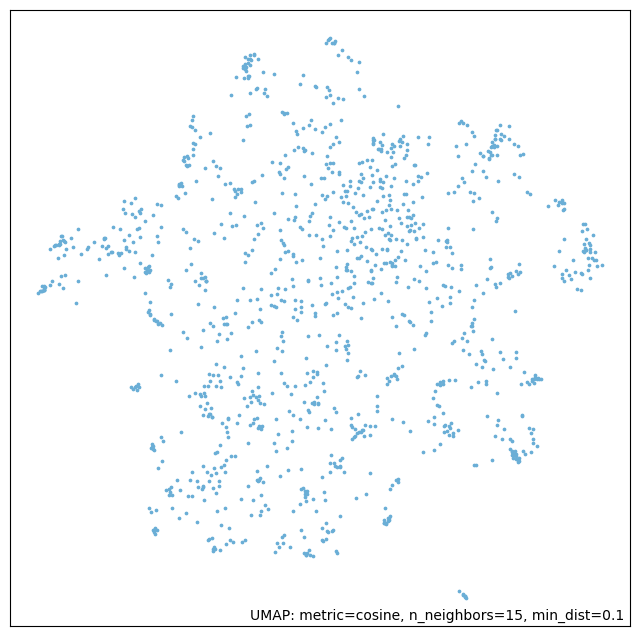

In [14]:
mapper = umap.UMAP(metric="cosine", random_state=0).fit(data.toarray())
umap.plot.points(mapper)
plt.show()

### BERT

Note: BERT is originally prepared to produce single/paired sentence embeddings. Its application for multiple sentences can produce suboptimal results. 

In [15]:
import torch
from transformers import BertModel, BertTokenizer

In [16]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', truncation=True, do_lower_case=True)

In [17]:
bert_model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)

In [18]:
print(bert_model.eval())

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [19]:
print("Total number of params", sum(p.numel() for p in bert_model.parameters()))

Total number of params 109482240


In [20]:
def get_bert_output(tokenizer, model, sentence, mode='cls', optype='sumsum'):
    tokenized_text = tokenizer.tokenize(sentence)
    tokens_tensor = torch.tensor([tokenizer.convert_tokens_to_ids(tokenized_text)])
    segments_tensors = torch.tensor([[1] * len(tokenized_text)])
    outputs = model(tokens_tensor, segments_tensors)
    if mode == 'cls': embedding = outputs["last_hidden_state"].squeeze()[0]
    elif mode == 'pooled': embedding = outputs["pooler_output"].squeeze()
    else: #'hidden'
        layers = torch.stack(outputs['hidden_states'][-4:])
        if optype == "sumsum": embedding = torch.sum(layers.sum(0).squeeze(), dim=0) 
        elif optype == "summean": embedding = torch.sum(layers.mean(0).squeeze(), dim=0) 
        elif optype == "meanmean": embedding = torch.mean(layers.mean(0).squeeze(), dim=0)    
        else: embedding = torch.mean(layers.sum(0).squeeze(), dim=0)  
    return embedding.detach().numpy()

In [21]:
get_bert_output(tokenizer, bert_model, "[CLS] "+collection[0]+" [SEP]", mode='cls')[0:9]

array([-0.4561753 , -0.5301135 , -0.29728958,  0.02394348, -0.33440864,
        0.2635137 ,  0.3446321 , -0.506187  ,  0.28424656], dtype=float32)

In [22]:
get_bert_output(tokenizer, bert_model, "[CLS] "+collection[0]+" [SEP]", mode='pooled')[0:9]

array([-0.7401288 , -0.44892102, -0.9735255 ,  0.42736003,  0.7727596 ,
       -0.22928077, -0.21906333,  0.4749321 , -0.92802566], dtype=float32)

In [23]:
get_bert_output(tokenizer, bert_model, "[CLS] "+collection[0]+" [SEP]", mode='hidden')[0:9]

array([-483.43835 ,   10.472988,  -31.468983,  -56.229652,  228.75642 ,
        113.3151  ,  252.74164 ,  -63.401913,  153.59592 ], dtype=float32)

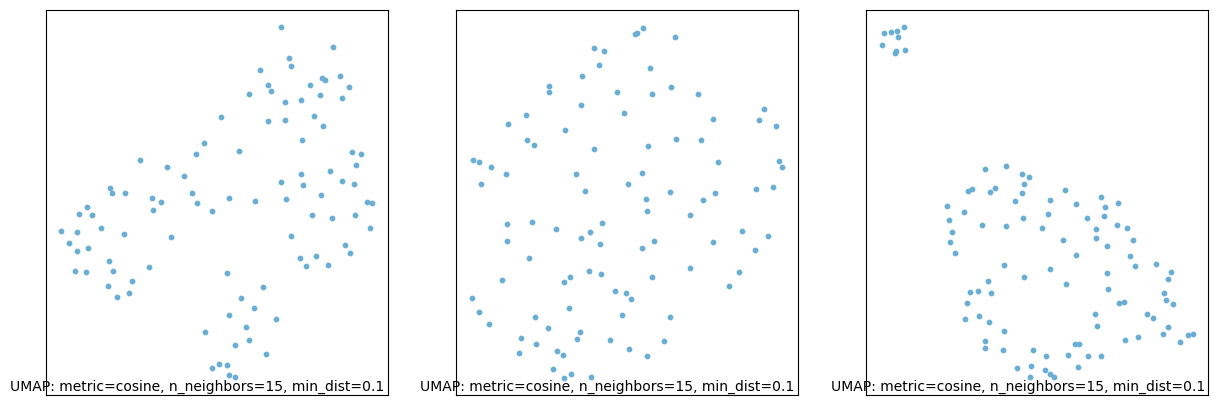

In [24]:
fig, axs = plt.subplots(1,3,figsize = (15,5))
for i, mode in enumerate(['cls','hidden','pooled']):
    embeddings = np.array([get_bert_output(tokenizer,bert_model,s,mode=mode) for s in collection[0:100]])
    bert_mapper = umap.UMAP(metric="cosine", random_state=0).fit(embeddings)
    umap.plot.points(bert_mapper, width=200, height=200, ax=axs[i])
plt.show()